<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/HandsOn10_Training_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training CNNs and Neural Networks

In this notebook, we will explore how to train Multilayer Neural Networks and Convolutional Neural Networks (CNNs). Specifically, we will use keras to:
- train and evaluate a CNN on a 5-class dataset
- explore a couple of techniques to train CNNs better
- study transfer learning and finetuning
- build a simple multi layer perceptron


**Enabling GPU in Colab** Go to Edit | Notebook Settings and make sure you have enabled _Hardware Accelerator - GPU_

**Install required libraries (if missing)**

In [ ]:
#!pip install pandas
#!pip install sklearn
#!pip install seaborn
#!pip install gluon mxnet-cu101

#!pip install --upgrade xlrd

!apt-get install python-opencv
!pip install kaggle
!pip install imutils
!pip install mmdnn
!apt-get install tree
!pip install visualkeras


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  python-opencv
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 535 kB of archives.
After this operation, 2,944 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [535 kB]
Fetched 535 kB in 2s (327 kB/s)
Selecting previously unselected package python-opencv.
(Reading database ... 155653 files and directories currently installed.)
Preparing to unpack .../python-opencv_3.2.0+dfsg-4ubuntu0.1_amd64.deb ...
Unpacking python-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Setting up python-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

**Import the required libraries**

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json
import cv2
import requests 
from imutils import paths
from google.colab import drive, files
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


#Disable warnings (Not a good idea in general, but helps clean output for today)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Check the tensorflow version GPU allocated
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

2.8.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Jul 20 14:08:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
               

#Kaggle API integration

Kaggle hosts a lot of datasets through competitions which can be downloaded straight into Colab. The steps needed to setup the integration are listed [here](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/):

- Go to https://www.kaggle.com  
- Click on _Account_ tab under user profile 
- Select _Create API Token_. This downloads kaggle.json file to your local machine. 

For this notebook, the file is already downloaded in the local. 


In [ ]:
# Upload file to Colab

uploaded = files.upload()

for fn in uploaded.keys():
  print('Uploaded file "{name}";  {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Move the file to appropriate location for API
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


#Dataset

We will use the data prepared for [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification)

Background: ```Cassava consists of leaf images for the cassava plant depicting healthy and
four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
Dataset consists of a total of 9430 labelled images.
The 9430 labelled images are split into a training set (5656), a test set(1885)
and a validation set (1889). The number of images per class are unbalanced with
the two disease classes CMD and CBSD having 72% of the images.```

Citation: _Mwebaze, E., Gebru, T., Frome, A., Nsumba, S., & Tusubira, J. (2019). iCassava 2019 fine-grained visual categorization challenge. arXiv preprint arXiv:1908.02900._

In [ ]:
# Download the dataset using Kaggle API
#!kaggle competitions download cassava-leaf-disease-classification

In [ ]:
# The data (along with test data) has been uploaded to Google drive for this notebook. 

#Mount Google Drive
drive.mount('/content/drive')

#Download file to Google Drive Folder

#Commented as it is already run
gdrive_folder = '/content/drive/MyDrive/5450_Summer22/cassavaleafdata.zip'
file_url = "https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip"
    
r = requests.get(file_url, stream = True) 
  
with open(gdrive_folder, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block) 


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/5450_Summer22/cassavaleafdata.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: data/cassavaleafdata/train/cgm/train-cgm-6

Let's look at how the data is structured.

In [ ]:
!tree data/cassavaleafdata/ -d -C

data/cassavaleafdata/
├── test
│   ├── cbb
│   ├── cbsd
│   ├── cgm
│   ├── cmd
│   └── healthy
├── train
│   ├── cbb
│   ├── cbsd
│   ├── cgm
│   ├── cmd
│   └── healthy
└── validation
    ├── cbb
    ├── cbsd
    ├── cgm
    ├── cmd
    └── healthy

18 directories


*Question*: What is the utility of having a validation and a test dataset?

In [ ]:
!dir data/cassavaleafdata/train/cbb

train-cbb-0.jpg    train-cbb-205.jpg  train-cbb-310.jpg  train-cbb-416.jpg
train-cbb-100.jpg  train-cbb-206.jpg  train-cbb-311.jpg  train-cbb-417.jpg
train-cbb-101.jpg  train-cbb-207.jpg  train-cbb-312.jpg  train-cbb-418.jpg
train-cbb-102.jpg  train-cbb-208.jpg  train-cbb-313.jpg  train-cbb-419.jpg
train-cbb-103.jpg  train-cbb-209.jpg  train-cbb-314.jpg  train-cbb-41.jpg
train-cbb-104.jpg  train-cbb-20.jpg   train-cbb-315.jpg  train-cbb-420.jpg
train-cbb-105.jpg  train-cbb-210.jpg  train-cbb-316.jpg  train-cbb-421.jpg
train-cbb-106.jpg  train-cbb-211.jpg  train-cbb-317.jpg  train-cbb-422.jpg
train-cbb-107.jpg  train-cbb-212.jpg  train-cbb-318.jpg  train-cbb-423.jpg
train-cbb-108.jpg  train-cbb-213.jpg  train-cbb-319.jpg  train-cbb-424.jpg
train-cbb-109.jpg  train-cbb-214.jpg  train-cbb-31.jpg	 train-cbb-425.jpg
train-cbb-10.jpg   train-cbb-215.jpg  train-cbb-320.jpg  train-cbb-426.jpg
train-cbb-110.jpg  train-cbb-216.jpg  train-cbb-321.jpg  train-cbb-427.jpg
train-cbb-111.jpg  train-cb

Each class folder is nested in the train, validation, and test folders. The test images were not released during the competition, but were released later. 

In [ ]:
data_dir = 'data/cassavaleafdata/'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

#Loading data into Keras Dataset

Keras has several useful functions to load and preprocess images from folder structure we saw above. Let's explore them below.

In [ ]:
# Data Preprocessing
# Changing these parameters will impact both time and performance of model training
batch_size = 64
img_height = 224
img_width = 224

*Question*: How do the these parameters impact model learning?
- image size
- batch_size
- learning rate
- activation function

In [ ]:
#Loading train, validation, and test datasets into keras dataset format
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5656 files belonging to 5 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1889 files belonging to 5 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1885 files belonging to 5 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

#Cassava Bacterial Blight (CBB), Cassava Brown Streak Disease (CBSD), Cassava Greem Mite (CGM) and Cassava Mosaic Disease (CMD), Healthy

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [ ]:
# Extracting a few basic descriptives from keras dataset object
# For example, class frequencies
y = np.concatenate([y for x, y in train_ds], axis=0)

unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  466]
 [   1 1443]
 [   2  773]
 [   3 2658]
 [   4  316]]


Let's now look at a few sample images

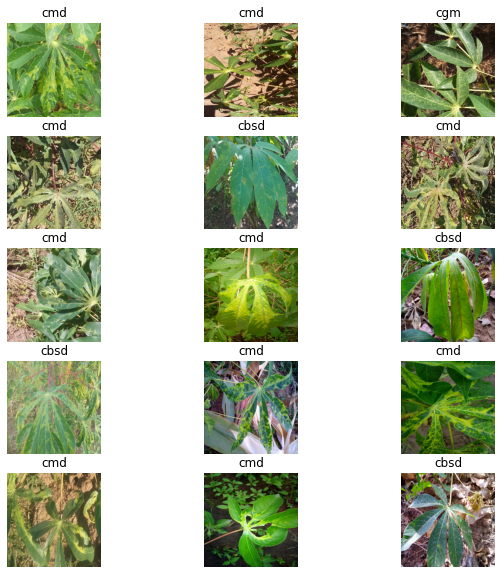

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image, label in train_ds.take(1):
  print(images[0].numpy().astype("uint8"))


[[[141 175  62]
  [123 159  53]
  [142 180  80]
  ...
  [ 96 131  49]
  [ 98 133  46]
  [ 97 131  44]]

 [[153 189  78]
  [112 149  45]
  [142 179  83]
  ...
  [105 140  57]
  [ 99 134  47]
  [ 99 133  46]]

 [[115 154  48]
  [111 150  50]
  [152 189  94]
  ...
  [ 95 130  46]
  [ 96 132  45]
  [105 139  52]]

 ...

 [[ 94 134  72]
  [ 52  84  32]
  [ 61  87  45]
  ...
  [110 171  93]
  [109 170  93]
  [106 167  90]]

 [[ 63  78  29]
  [139 153  98]
  [229 244 180]
  ...
  [112 170  94]
  [105 166  90]
  [107 167  93]]

 [[204 221 128]
  [192 209 117]
  [171 189  91]
  ...
  [113 171  95]
  [112 173  97]
  [111 171  97]]]


The dataset consists of 3 channel RGB images. Each pixel has value between 0 and 255. We can use division by 255 as one of the ways to standardize them. 

Keras provides an option to do this operation within the model specification in the form of a layer. 

#Model Definition

Let's look at how we can go about defining a very simple CNN.

In [ ]:
num_classes = 5

model_v1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

Let's now visualize the model using [visualkeras](https://github.com/paulgavrikov/visualkeras)

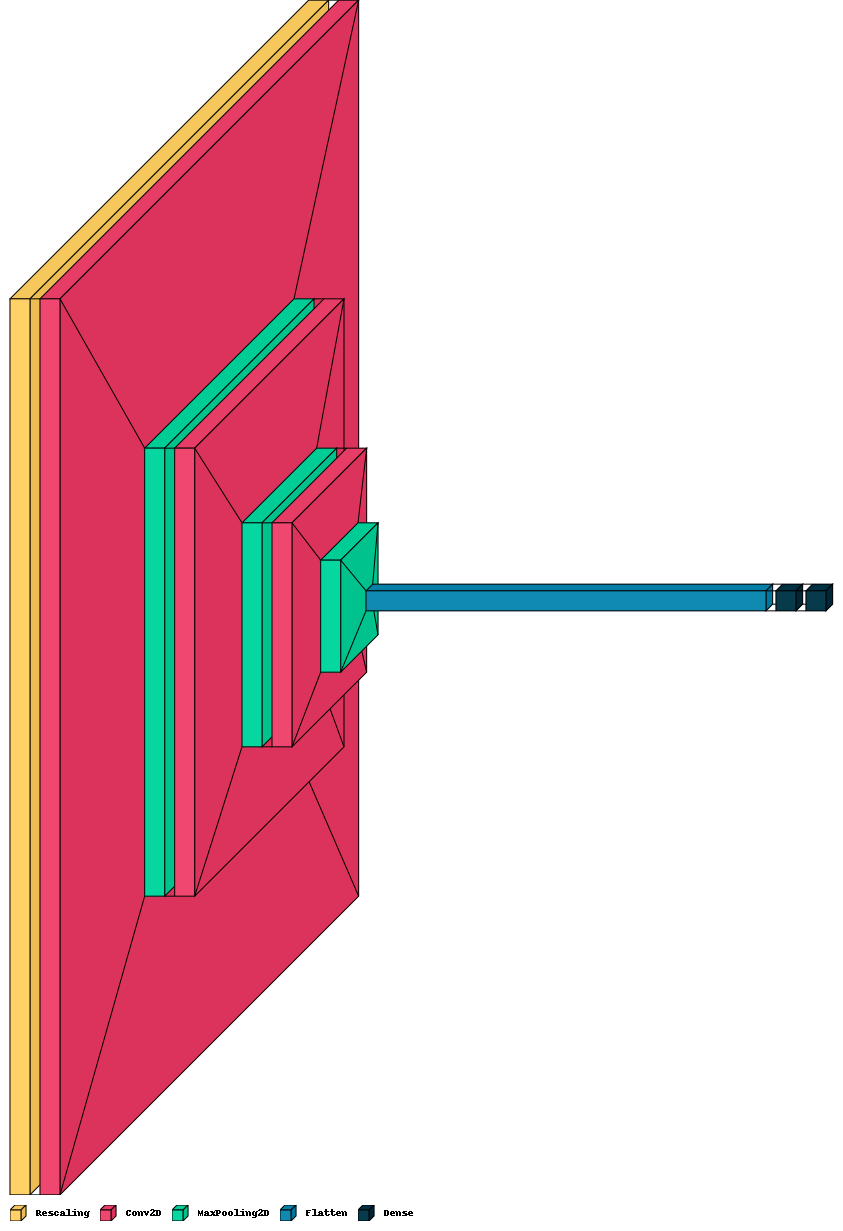

<Figure size 360x360 with 0 Axes>

In [ ]:
import visualkeras

from PIL import ImageFont
plt.figure(figsize=(5, 5))
font = ImageFont.load_default()
visualkeras.layered_view(model_v1, legend=True, font=font)

Now that we defined the model, we can select select parameters to train it. For example:
- Optimizer: adam, sgd, rmsprop, ...
- Loss functions: MeanSquaredError, KLDivergence, CosineSimilarity, ...
- Metrics to report: Accuracy, AUC, F1, Precision, Recall, ...

Here are a couple of resources on how to go about choosing them. [1](https://analyticsarora.com/complete-glossary-of-keras-optimizers-and-when-to-use-them-with-code/) and [2](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/#:~:text=The%20mean%20squared%20error%20loss,function%20when%20compiling%20the%20model.&text=It%20is%20recommended%20that%20the,linear%20activation%20function%20is%20used.)

[This](https://karpathy.github.io/2019/04/25/recipe/) is a great resource by Andrej Karpathy on training neural networks in general.  

In [ ]:
#Compile the model
model_v1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Define number of epochs to run
epochs=10

#Start training
history = model_v1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
89/89 [==============================] - 34s 235ms/step - loss: 1.4204 - accuracy: 0.4576 - val_loss: 1.2595 - val_accuracy: 0.5109
Epoch 2/10
89/89 [==============================] - 21s 221ms/step - loss: 1.2134 - accuracy: 0.5461 - val_loss: 1.1821 - val_accuracy: 0.5511
Epoch 3/10
89/89 [==============================] - 21s 221ms/step - loss: 1.1004 - accuracy: 0.5918 - val_loss: 1.0579 - val_accuracy: 0.6204
Epoch 4/10
89/89 [==============================] - 21s 222ms/step - loss: 1.0191 - accuracy: 0.6204 - val_loss: 1.0286 - val_accuracy: 0.6093
Epoch 5/10
89/89 [==============================] - 23s 245ms/step - loss: 0.9400 - accuracy: 0.6377 - val_loss: 1.0685 - val_accuracy: 0.6083
Epoch 6/10
89/89 [==============================] - 21s 223ms/step - loss: 0.8043 - accuracy: 0.6943 - val_loss: 1.1365 - val_accuracy: 0.6088
Epoch 7/10
89/89 [==============================] - 21s 223ms/step - loss: 0.6202 - accuracy: 0.7749 - val_loss: 1.2232 - val_accuracy: 0.5929

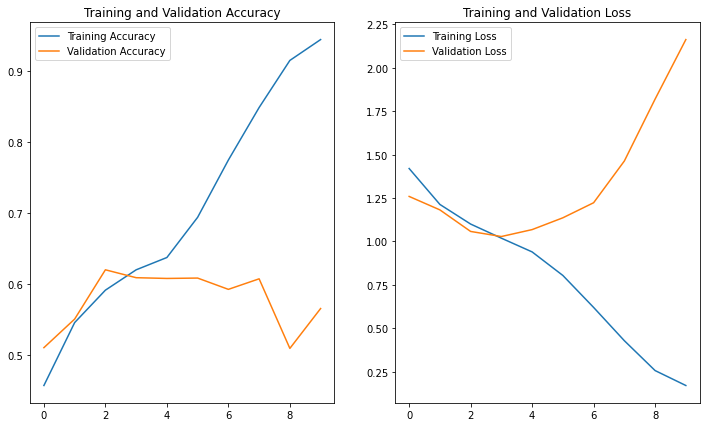

In [ ]:
#Printing the accuracy and loss on the training set and the validation set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

What's going on with the training process? Is the model generalizing to data beyond the training set?

*Question*: How do we address it? 



- Data Augmentation [improves the completeness of the training data -- increases variance in the kind of examples the model might see]
- Regularization: Dropout, L2, etc.
- Early stopping [stop training when validation loss increases instead of running through all epochs]
- Starting with a model trained on a very large dataset

###Data Augmentation

Let's define a layer that creates additional datapoints based on:
- horizontal flip
- rotation
- zoom

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's look at some of these augmented images for the same image.

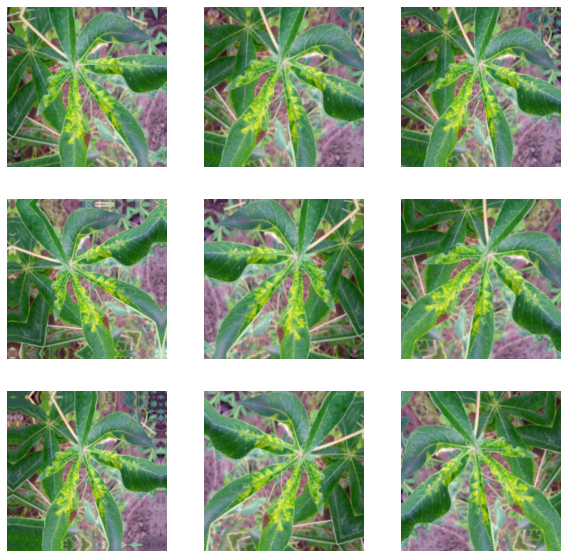

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(10):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

###Other methods to avoid overfitting

Now let's also add dropout and L2 regularization to the model layers

In [ ]:
model_v2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', kernel_regularizer = regularizers.L2(0.001), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', kernel_regularizer = regularizers.L2(0.001), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', kernel_regularizer = regularizers.L2(0.001), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Dropout(0.1),

  layers.Flatten(),
  layers.Dense(128,  activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)     

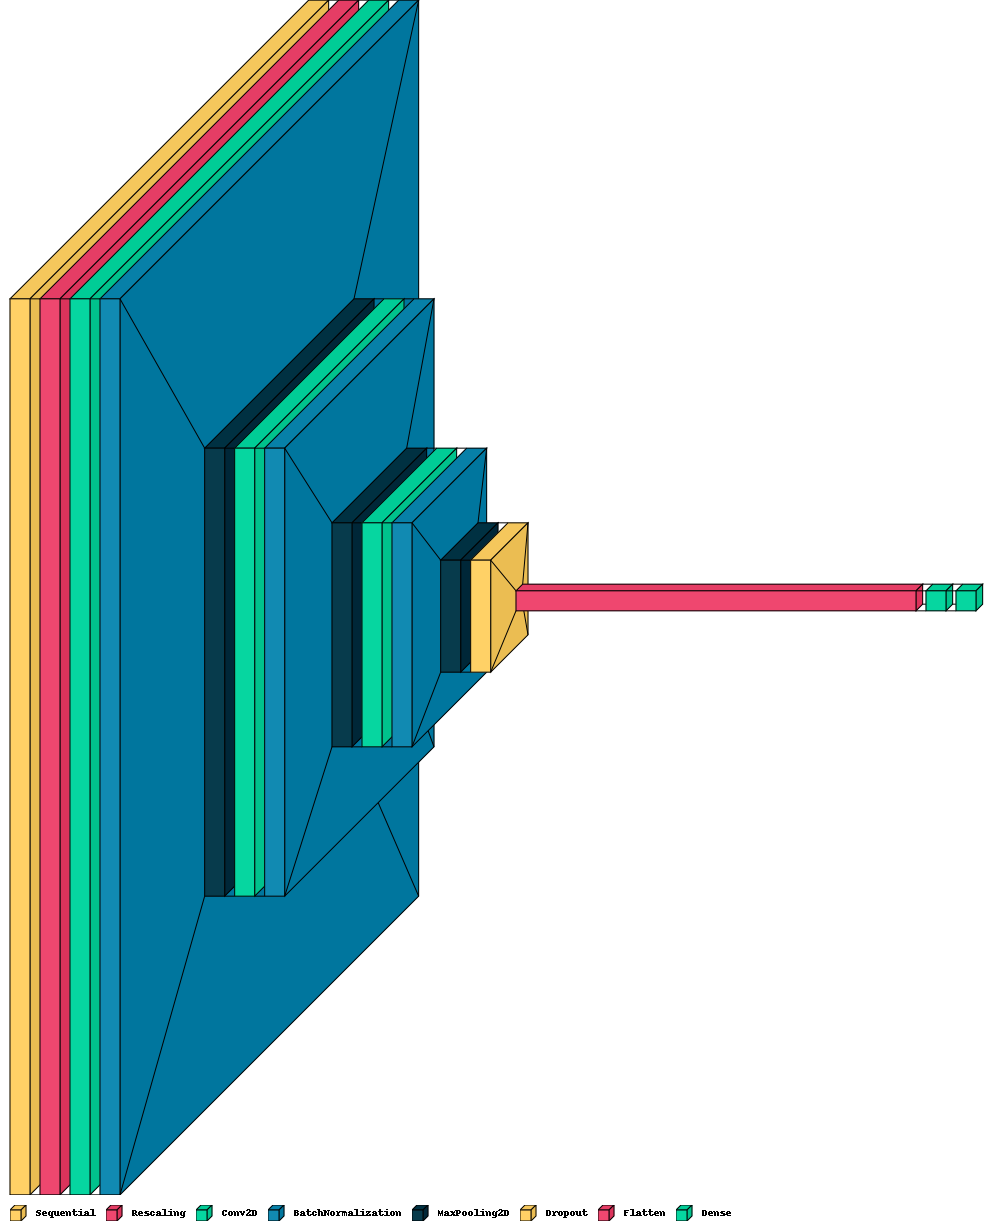

<Figure size 360x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(5, 5))
font = ImageFont.load_default()
visualkeras.layered_view(model_v2, legend=True, font=font)

In [ ]:
#Compile model v2
model_v2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Notice in this plot from model v1:

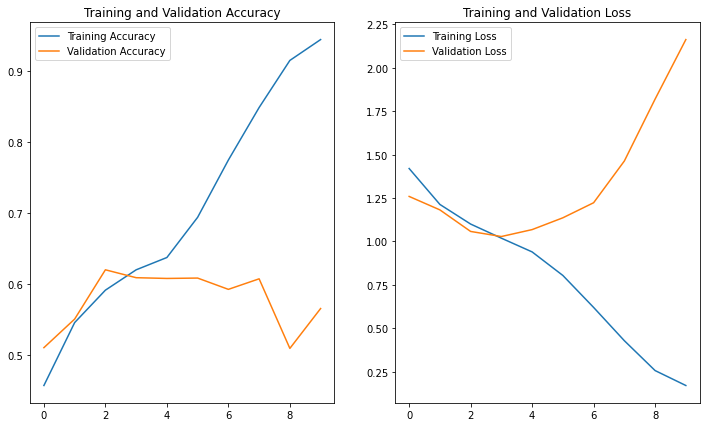

that we might want to use a model at a certain epoch to maximize performance. Keras lets us save checkpoints of models at every epoch. 

Saving checkpoints is also useful to save progress in case the GPU runtime is expired. We can resume training from any checkpoint. 

In [ ]:
from keras.callbacks import *
#naming the files appropriately can be huge gamechanger!
filepath="/content/drive/MyDrive/5450_Summer22/CNN_checkpoints/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1,
                             save_best_only=False,
                             save_freq='epoch',     
                             mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Train model v2
epochs = 10
history = model_v2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list
)

Epoch 1/10
88/89 [============================>.] - ETA: 0s - loss: 3.3540 - accuracy: 0.4544
Epoch 1: saving model to /content/drive/MyDrive/5450_Summer22/CNN_checkpoints/epochs:001-val_accuracy:0.065.hdf5
89/89 [==============================] - 24s 241ms/step - loss: 3.3460 - accuracy: 0.4544 - val_loss: 48.6416 - val_accuracy: 0.0646
Epoch 2/10
88/89 [============================>.] - ETA: 0s - loss: 1.2599 - accuracy: 0.5778
Epoch 2: saving model to /content/drive/MyDrive/5450_Summer22/CNN_checkpoints/epochs:002-val_accuracy:0.219.hdf5
89/89 [==============================] - 22s 231ms/step - loss: 1.2581 - accuracy: 0.5783 - val_loss: 7.8227 - val_accuracy: 0.2192
Epoch 3/10
88/89 [============================>.] - ETA: 0s - loss: 1.1758 - accuracy: 0.5948
Epoch 3: saving model to /content/drive/MyDrive/5450_Summer22/CNN_checkpoints/epochs:003-val_accuracy:0.513.hdf5
89/89 [==============================] - 22s 233ms/step - loss: 1.1755 - accuracy: 0.5955 - val_loss: 1.9135 - val

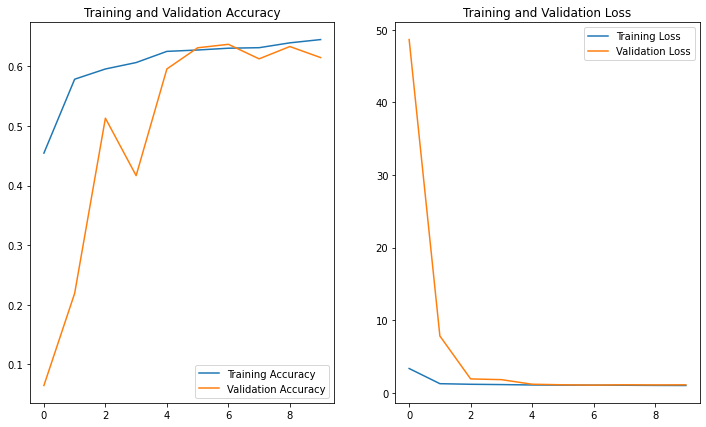

In [ ]:
#Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now let's try loading a pre-trained model whose weights were obtained by training the architecture called [XceptionNet](https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf) on ImageNet dataset which has millions of images. 

This process is typically called [transfer-learning](https://keras.io/guides/transfer_learning/). 

*Question*: Why is this called transfer learning?

In [ ]:
# Using a pretrained model
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes)(x)
model_v3 = keras.Model(inputs, outputs)

model_v3.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0      

Compare the number of paramets in our simple model vs XceptionNet! 

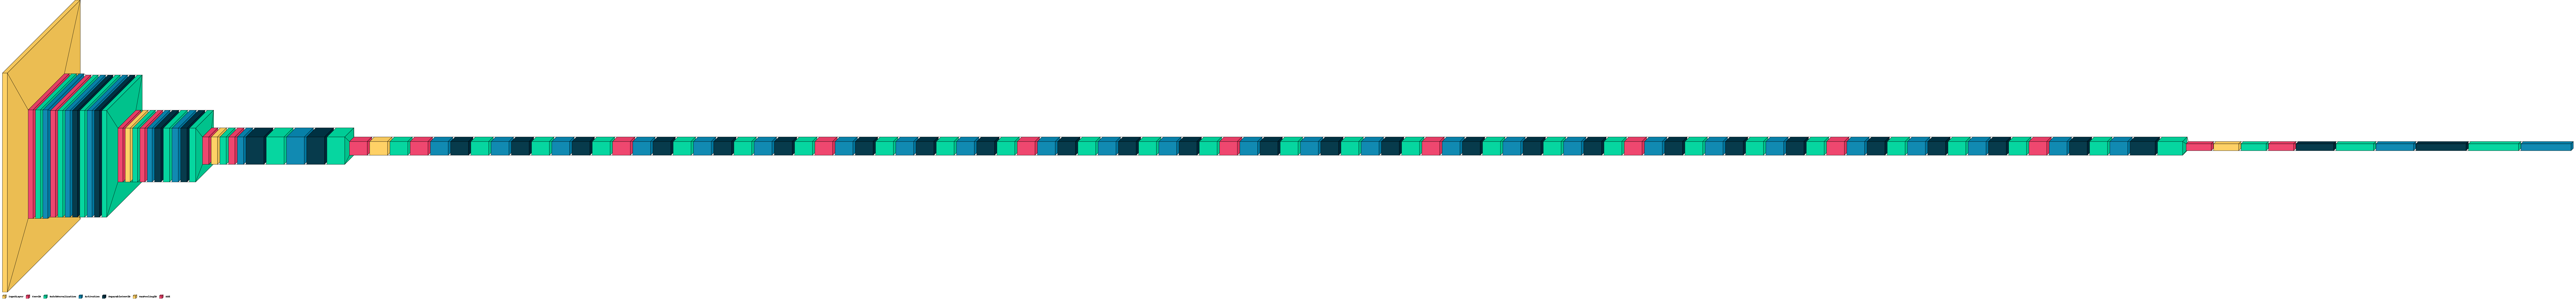

<Figure size 360x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(5, 5))
font = ImageFont.load_default()
visualkeras.layered_view(base_model, legend=True, font=font)

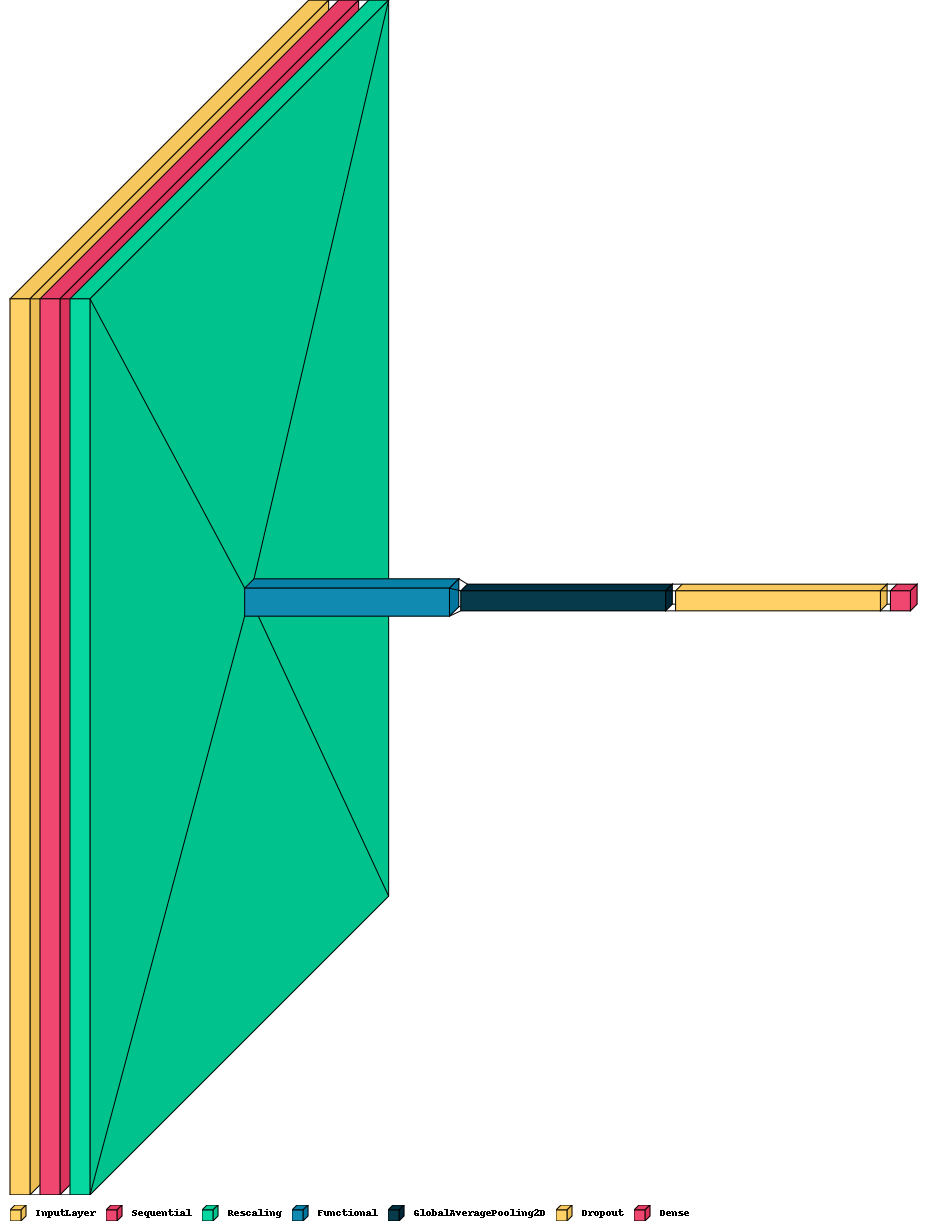

<Figure size 360x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(5, 5))
font = ImageFont.load_default()
visualkeras.layered_view(model_v3, legend=True, font=font)

In [ ]:
#Compile and train model v3
model_v3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 10
history = model_v3.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
89/89 [==============================] - 47s 460ms/step - loss: 1.1158 - accuracy: 0.5836 - val_loss: 0.9110 - val_accuracy: 0.6707
Epoch 2/10
89/89 [==============================] - 38s 413ms/step - loss: 0.9173 - accuracy: 0.6517 - val_loss: 0.8903 - val_accuracy: 0.6765
Epoch 3/10
89/89 [==============================] - 38s 417ms/step - loss: 0.8727 - accuracy: 0.6766 - val_loss: 0.8287 - val_accuracy: 0.7014
Epoch 4/10
89/89 [==============================] - 38s 415ms/step - loss: 0.8367 - accuracy: 0.6915 - val_loss: 0.8058 - val_accuracy: 0.7110
Epoch 5/10
89/89 [==============================] - 40s 422ms/step - loss: 0.8180 - accuracy: 0.6908 - val_loss: 0.8135 - val_accuracy: 0.6998
Epoch 6/10
89/89 [==============================] - 38s 415ms/step - loss: 0.8079 - accuracy: 0.7053 - val_loss: 0.7938 - val_accuracy: 0.7125
Epoch 7/10
89/89 [==============================] - 38s 416ms/step - loss: 0.7914 - accuracy: 0.7104 - val_loss: 0.8258 - val_accuracy: 0.6998

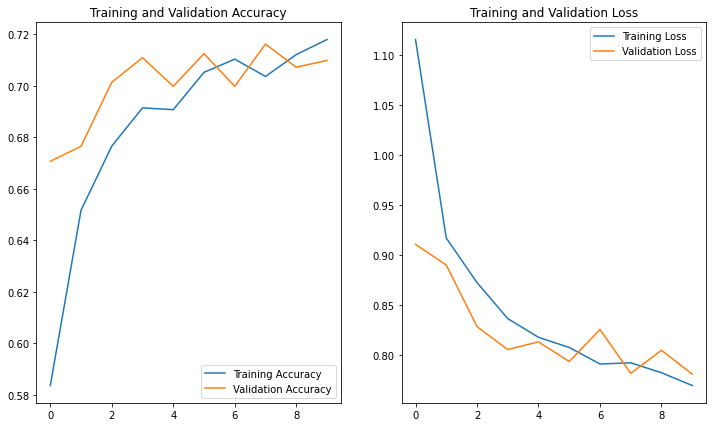

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We have seen transfer learning where the base model was frozen and other layers with weights were trained. 

Now let's 'fine-tune' the model by training the weights of the base model!

*Question* What is the difference between the approach we used in the previous step (transfer learning) and this?

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model_v4 = keras.Model(inputs, outputs)

model_v4.summary()

#Train model v4
model_v4.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 10
history = model_v4.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

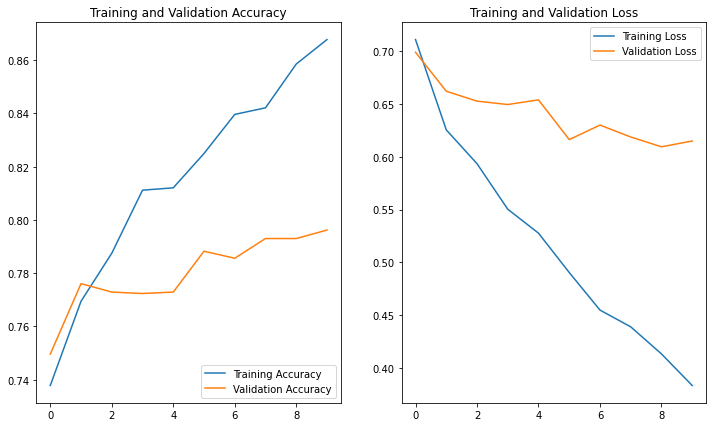

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So far we have seen:
- model v1: 3 convolutional layers and 2 dense layers
- model v2: same as model v1 but with dropout and regularizaion
- model v3: transfer weights from XceptionNet trained on ImageNet and train weights on dense layer (71 layers + 6 layers)
- model v4: fine-tuning XceptionNet (with low learning rate)

Note that all the accuracies so far were on validation set. Now, let's see how the model v4 performs on the real test dataset. 

In [ ]:
# Applying model v4 on test data
results_test_set = model_v4.evaluate(test_ds)
print('Performance Metrics of Model V4')
print(f'Test loss: {results_test_set[0]} / Test accuracy: {results_test_set[1]}')

30/30 [==============================] - 12s 340ms/step - loss: 0.5813 - accuracy: 0.8048
Performance Metrics of Model V4
Test loss: 0.5813148617744446 / Test accuracy: 0.8047745227813721


Obtaining the classes from prefecthed tf dataset is hard! 

Fortunately, stackoverflow comes to our rescue!
https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_v4.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
confusion_matrix(predicted_labels, correct_labels)

array([[ 67,  26,   9,   0,   0],
       [ 48, 392,  23,  30,   5],
       [ 10,   6, 161,  19,   0],
       [  8,  23,  47, 801,   4],
       [ 22,  34,  18,  36,  96]])

In [ ]:
print('Classification Report of Model V4')
print(classification_report(correct_labels,predicted_labels))

Classification Report of Model V4
              precision    recall  f1-score   support

           0       0.66      0.43      0.52       155
           1       0.79      0.81      0.80       481
           2       0.82      0.62      0.71       258
           3       0.91      0.90      0.91       886
           4       0.47      0.91      0.62       105

    accuracy                           0.80      1885
   macro avg       0.73      0.74      0.71      1885
weighted avg       0.82      0.80      0.80      1885



Here are a few things to try out if you're interested!
- Train a MLP with no convolution layers and compare its performance with models v1-4
- Identify which images Model V4 is mislabeling, and why? 
- Evaluate what happens if you have a very large learning rate in any of the CNN models (v1-4)
- Convert the keras tensorflow model to MXNet or pytorch and visualize the model. [This repo](https://github.com/ysh329/deep-learning-model-convertor) has a good chart on which library to use for converting to/from different frameworks.

In [ ]:
#[TODO] Simple NN

# Question -- What layers would we use to construct the MLP? 
num_classes=5
# Define model architecture
model_mlp = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(100, activation='relu'),
  layers.Dense(num_classes)
])

# Configure the model and start training
model_mlp.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [ ]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               19267712  
                                                                 
 dense_3 (Dense)             (None, 100)               12900     
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
Total params: 19,281,117
Trainable params: 19,281,117
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_mlp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


NameError: ignored

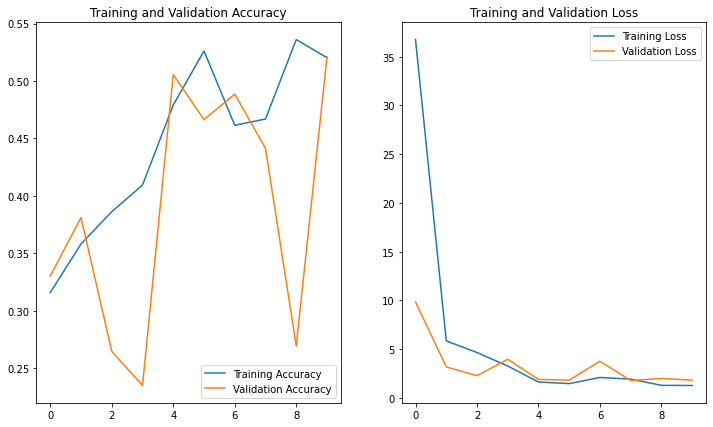

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Apply MLP on test set
results_test_set = model_mlp.evaluate(test_ds)
print(f'Test loss: {results_test_set[0]} / Test accuracy: {results_test_set[1]}')

# Obtain predictions on the test set
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:  
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_mlp.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print('Classification Report of MLP')
print(classification_report(correct_labels,predicted_labels))

30/30 [==============================] - 5s 121ms/step - loss: 1.8027 - accuracy: 0.5279
Test loss: 1.802686333656311 / Test accuracy: 0.5278514623641968
Classification Report of MLP
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.47      0.42      0.44       481
           2       0.00      0.00      0.00       258
           3       0.54      0.90      0.68       886
           4       0.00      0.00      0.00       105

    accuracy                           0.53      1885
   macro avg       0.20      0.26      0.22      1885
weighted avg       0.38      0.53      0.43      1885



#Interpreting the Black Box (Resources)

While CNNs have been treated as a blackbox, there are several advances in interpreting what the networks are learning and understanding how model predictions work (e.g. which regions of an image did the model see to decide that it belongs to a certain class). 

Here are a few resources. 
- [Visualizing Keras CNN attention: Grad-CAM Class Activation Maps](https://github.com/christianversloot/machine-learning-articles/blob/main/visualizing-keras-cnn-attention-grad-cam-class-activation-maps.md)
- [Visualizing Keras CNN attention: Saliency maps](https://github.com/christianversloot/machine-learning-articles/blob/main/visualizing-keras-cnn-attention-saliency-maps.md)
- [What do ConvNets see? Visualizing filters with Activation Maximization](https://github.com/christianversloot/machine-learning-articles/blob/main/what-do-convnets-see-visualizing-filters-with-activation-maximization.md)
- [Visualizing CNN Feature Maps](https://github.com/fg91/visualizing-cnn-feature-maps)